#### Imports

In [3263]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ps

#### Preparing dataset for ML model

In [3264]:
linkedin = pd.read_csv('../data/linkedin_standarized.csv')
linkedin.sample(5)

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size,image_link,employees,salary,original_title
503,3770198438,Data Engineer,Eliassen Group,OH,70 $/h - 75 $/h,Híbrido,Contrato por obra,Intermedio,L,https://media.licdn.com/dms/image/C560BAQEF3Co...,De 1.001 a 5.000 empleados,139200.0,Data Engineer
54,3711696827,Data Scientist,The Lubrizol Corporation,OH,70.000 $/yr,En remoto,Jornada completa,Intermedio,L,https://media.licdn.com/dms/image/C560BAQHgFRl...,De 5.001 a 10.000 empleados,70000.0,Data Scientist / Statistician Intern Summer 20...
160,3752871763,Machine Learning Engineer,Red Oak Technologies,TX,48 $/h - 65 $/h,En remoto,Contrato por obra,Intermedio,L,https://media.licdn.com/dms/image/C4E0BAQETw9l...,De 501 a 1.000 empleados,108480.0,Machine Learning Engineer
568,3772986290,Data Engineer,"Ibotta, Inc.",CO,28 $/h - 30 $/h,Presencial,Jornada completa,Sin experiencia,L,https://media.licdn.com/dms/image/C560BAQGHAjy...,De 501 a 1.000 empleados,55680.0,Data Engineer
511,3771024354,Data Engineer,Northrop Grumman,FL,33.200 $/año - 53.000 $/año,En remoto,Jornada completa,Prácticas,L,https://media.licdn.com/dms/image/C4E0BAQFnJf3...,Más de 10.001 empleados,43100.0,Data Scientist/Data Engineer


In [3265]:
linkedin.shape
linkedin['company_size'].value_counts()

company_size
L    536
M    220
S     31
Name: count, dtype: int64

First we need to see which columns have null values.

In [3266]:
linkedin.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
salary_range        65
remote_ratio         0
employment_type      0
experience_level     0
company_size         0
image_link           0
employees            0
salary              69
original_title       0
dtype: int64

The ones with salary range in null value, are going to be the predicted ones.

In [3267]:
to_predict = linkedin[linkedin['salary'].isnull()]
to_predict.shape

(69, 13)

In [3268]:
linkedin = linkedin[~linkedin['salary'].isnull()]
linkedin.shape

(718, 13)

In [3269]:
linkedin = linkedin[linkedin['employment_type'] != 'Temporal']
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     570
Contrato por obra    120
Prácticas             28
Name: count, dtype: int64

Let's save this dataframe for sql queries.

In [3270]:
linkedin.to_csv('../data/linkedin_salaries_sql.csv', index=False)

Let's check again null values in order to delete those rows.

In [3271]:
linkedin.isna().sum()

job_id              0
job_title           0
company_name        0
company_state       0
salary_range        0
remote_ratio        0
employment_type     0
experience_level    0
company_size        0
image_link          0
employees           0
salary              0
original_title      0
dtype: int64

In [3272]:
linkedin = linkedin.dropna()

In [3273]:
linkedin.shape

(718, 13)

##### Function to clean both datasets

In [3274]:
prepared_to_predict = to_predict[~to_predict.drop(['salary', 'salary_range'], axis=1).isna().all(axis=1)]
prepared_to_predict.shape

(69, 13)

In [3275]:
prepared_to_predict.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
salary_range        65
remote_ratio         0
employment_type      0
experience_level     0
company_size         0
image_link           0
employees            0
salary              69
original_title       0
dtype: int64

In [3276]:
prepared_to_predict.shape

(69, 13)

    Column 'job_title'

Classificating the job_title category with numbers.

In [3277]:
linkedin.groupby('job_title')['salary'].mean().reset_index().sort_values(by='salary', ascending=False)

,job_title,salary
7,Deep Learning Engineer,173151.066667
8,Machine Learning Engineer,160196.896341
9,Research Engineer,149496.500000
6,Data Scientist,143585.000000
5,Data Engineer,133813.465116
1,BI Analyst,123222.750000
0,AI Engineer,117393.076923
4,Data Analyst,115355.708333
2,BI Engineer,84333.333333
3,Business Analyst,71470.000000


    Column 'remote_ratio'

In [3278]:
linkedin['remote_ratio'].value_counts()

remote_ratio
En remoto     280
Híbrido       238
Presencial    200
Name: count, dtype: int64

    Column 'employment_type'

In [3279]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     570
Contrato por obra    120
Prácticas             28
Name: count, dtype: int64

    Column 'experience_level'

In [3280]:
linkedin['experience_level'].value_counts()

experience_level
Intermedio                 348
Sin experiencia            248
Algo de responsabilidad     54
Prácticas                   51
Director                    15
Ejecutivo                    2
Name: count, dtype: int64

    Column 'company_size'

In [3281]:
linkedin['company_size'].value_counts()

company_size
L    488
M    202
S     28
Name: count, dtype: int64

#### Cleaning function

In [3282]:
def categorizing_dataset(dframe):
    # ------ Cleaning: group
    df = dframe.copy()

    # 1. job_title
    job_categories = {
        'Deep Learning Engineer': 10,
        'Machine Learning Engineer': 9,
        'Research Engineer': 8,
        'BI Analyst': 7,
        'Data Scientist': 6,
        'Data Engineer': 5,
        'Data Analyst': 4,
        'Business Analyst': 3,
        'AI Engineer': 2,
        'BI Engineer': 1
    }
    df["job_title"] = df.job_title.replace(job_categories)

    # 2. remote_ratio
    remote_categories = {
        'En remoto': 100,
        'Híbrido': 50,
        'Presencial': 0
    }
    df["remote_ratio"] = df.remote_ratio.replace(remote_categories)

    # 3. employment_type
    employment_type = {
        'Jornada completa': 4,
        'Media jornada': 3,
        'Contrato por obra': 2,
        'Prácticas': 1
    }
    df['employment_type'] = df.employment_type.replace(employment_type)

    # 4. experience_level
    experience_categories = {
        'Director': 6,
        'Ejecutivo': 5,
        'Algo de responsabilidad': 4,
        'Intermedio': 3,
        'Sin experiencia': 2,
        'Temporal': 1,
        'Prácticas': 0
    }
    df["experience_level"] = df.experience_level.replace(experience_categories)

    # 5. company_size
    oneonehotencoder = ps.OneHotEncoder()
    df[['L', 'M', 'S']] = oneonehotencoder.fit_transform(df["company_size"].values.reshape(-1, 1)).toarray()

    return df

In [3283]:
linkedin['company_size'].unique()

array(['M', 'L', 'S'], dtype=object)

In [3284]:
prepared_linkedin = categorizing_dataset(linkedin)
prepared_linkedin.sample(5)

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size,image_link,employees,salary,original_title,L,M,S
570,3773061360,4,Cloudious LLC,NY,80.000 $/año - 95.000 $/año,0,4,2,L,https://media.licdn.com/dms/image/C560BAQEVNlC...,De 201 a 500 empleados,87500.0,Data Analyst,1.0,0.0,0.0
502,3770197255,9,Cynet Systems,NJ,55 $/h - 60 $/h,0,2,2,L,https://media.licdn.com/dms/image/D4D0BAQGvDjf...,De 1.001 a 5.000 empleados,110400.0,AI/ML Engineer,1.0,0.0,0.0
735,3776795942,5,UNCOMN,IL,140.000 $/año - 180.000 $/año,100,4,3,L,https://media.licdn.com/dms/image/D560BAQFkSRz...,De 201 a 500 empleados,160000.0,Data Engineer,1.0,0.0,0.0
92,3735019426,5,Magellan Health,USA,83.890 $/año - 142.610 $/año,100,4,3,L,https://media.licdn.com/dms/image/C4D0BAQH9gt-...,De 5.001 a 10.000 empleados,113250.0,Senior Data Loss Protection Engineer - Fully R...,1.0,0.0,0.0
68,3725452231,9,MemryX Inc.,MI,60.000 $/año - 90.000 $/año,100,2,2,M,https://media.licdn.com/dms/image/C560BAQGXqiA...,De 11 a 50 empleados,75000.0,Artificial Intelligence/Machine Learning Appli...,0.0,1.0,0.0


In [3285]:
prepared_to_predict = categorizing_dataset(prepared_to_predict)
prepared_to_predict.sample()

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size,image_link,employees,salary,original_title,L,M,S
279,3762626619,5,King County Library System,WA,"106.953,60 $/año - 130.000 $/año",0,4,3,L,https://media.licdn.com/dms/image/C4E0BAQEXO13...,De 1.001 a 5.000 empleados,NaN,Data Engineer,1.0,0.0,0.0


In [3286]:
prepared_to_predict['employment_type'].value_counts()

employment_type
1    43
3    22
4     4
Name: count, dtype: int64

In [3287]:
# Viz mantra
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from sklearn import metrics

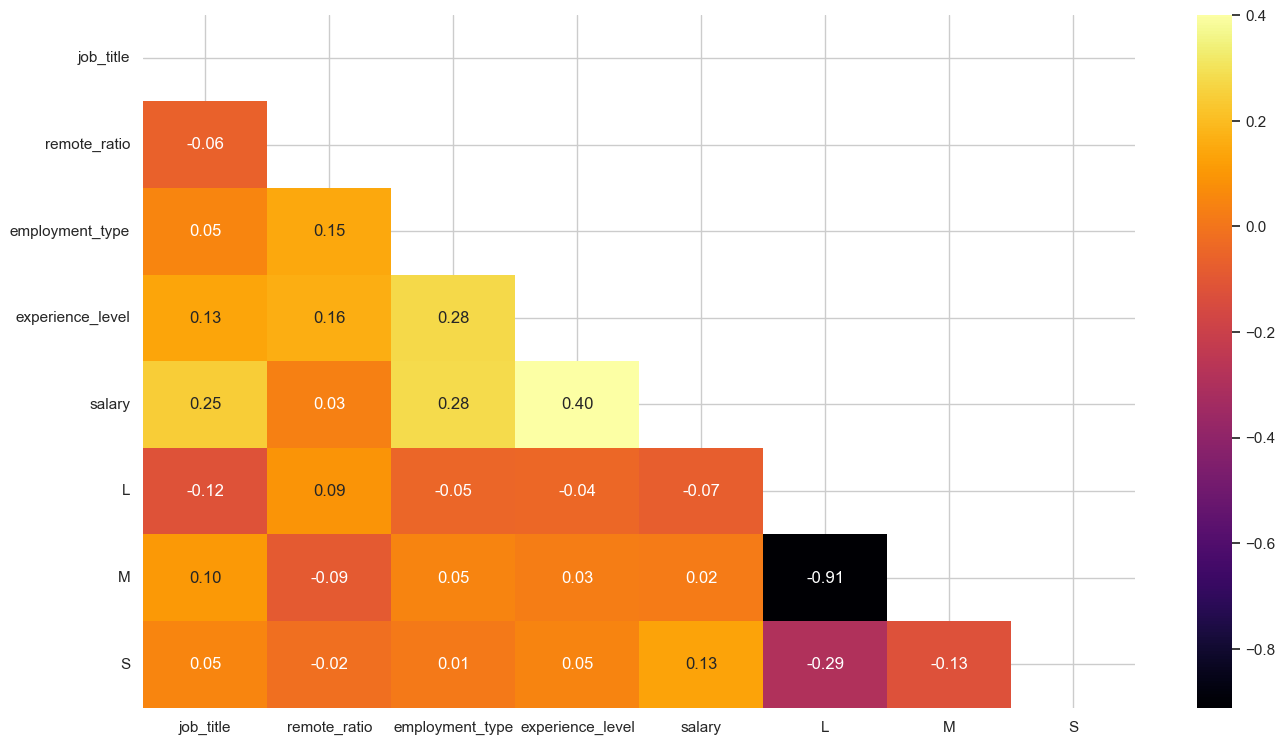

In [3288]:
corr = prepared_linkedin.select_dtypes(exclude=['object']).drop(columns=['job_id']).corr()
sns.heatmap(corr, annot=True, cmap='inferno', fmt='.2f', mask=np.triu(corr));

#### Models

In [3289]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [3290]:
prepared_linkedin.dtypes

job_id                int64
job_title             int64
company_name         object
company_state        object
salary_range         object
remote_ratio          int64
employment_type       int64
experience_level      int64
company_size         object
image_link           object
employees            object
salary              float64
original_title       object
L                   float64
M                   float64
S                   float64
dtype: object

In [3291]:
# X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary', 'min_salary', 'max_salary'])
X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary'])
y = prepared_linkedin['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [3292]:
X_train.shape

(574, 8)

    LinearRegression

In [3293]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [3294]:
y_pred = regressor.predict(X_test)

In [3295]:
metrics.r2_score(y_test, y_pred)

0.29461383739074465

    DecisionTreeRegressor

In [3296]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [3297]:
y_pred = regressor.predict(X_test)

In [3298]:
metrics.r2_score(y_test, y_pred)

0.4040151217276069

    KNeighborsRegressor

In [3299]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [3300]:
y_pred = regressor.predict(X_test)

In [3301]:
metrics.r2_score(y_test, y_pred)

0.37793740097612827

    GradientBoostingRegressor

In [3302]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [3303]:
y_pred = regressor.predict(X_test)

In [3304]:
r2_grad = metrics.r2_score(y_test, y_pred)
r2_grad

0.44100545463212504

    Code to save the model

In [3305]:
import pickle

# model_file = f'../models/GradientBoostingRegressor_r2_{r2_grad}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [3306]:
# model_file = '../models/GradientBoostingRegressor_r2_0.6336301605260248.pkl'
# with open(model_file, 'rb') as f:
#     model = pickle.load(f)

# pred = model.predict(X_test)
# # pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

# r2_pred = metrics.r2_score(y_test, pred)
# r2_pred

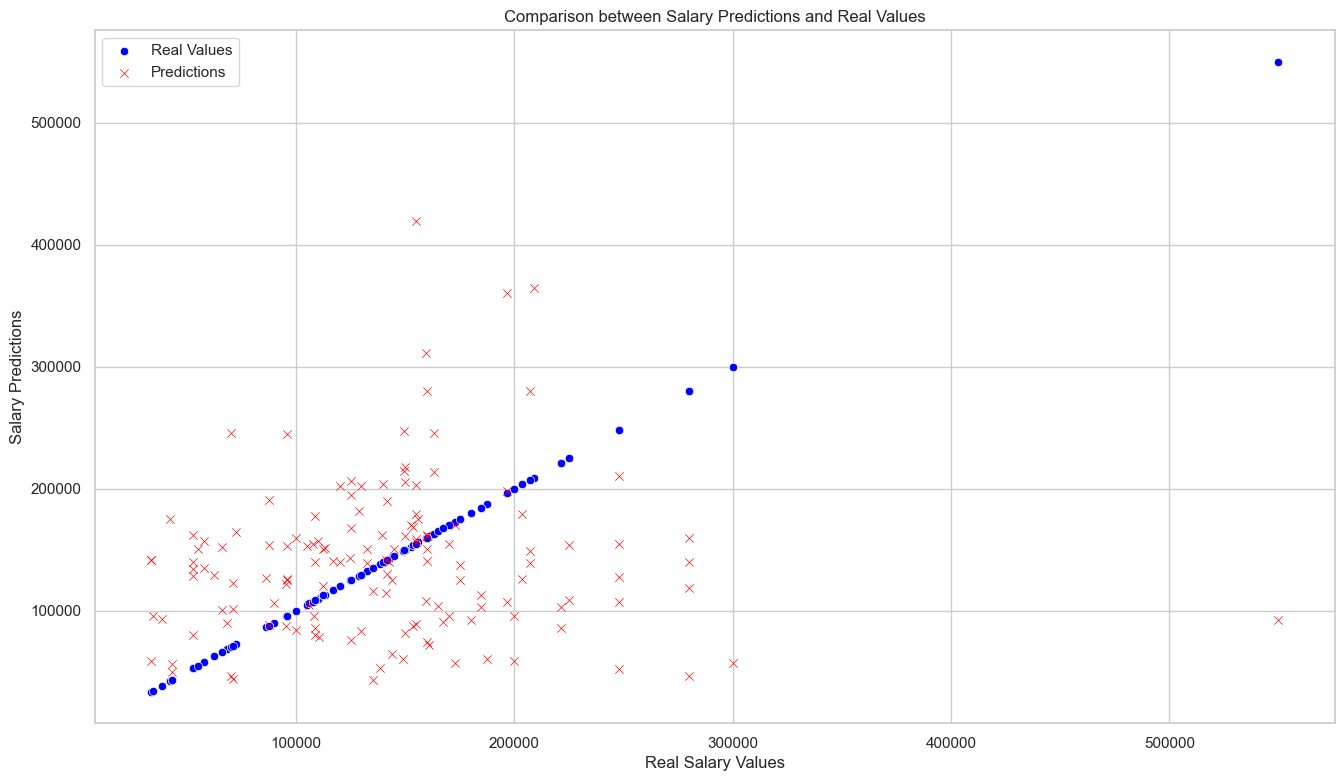

In [3307]:
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Real Values', marker='o')
sns.scatterplot(x=y_test, y=pred, color='red', label='Predictions', marker='x')

plt.xlabel('Real Salary Values')
plt.ylabel('Salary Predictions')
plt.title('Comparison between Salary Predictions and Real Values')
plt.legend()
# plt.savefig(f'../figures/RFRmodel_r2_{r2_pred}.jpg')
plt.show()

    RandomForestRegressor

In [3308]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [3309]:
y_pred = regressor.predict(X_test)

In [3310]:
r2 = metrics.r2_score(y_test, y_pred)
r2

0.4859176673748766

    Code to save the model

In [3311]:
import pickle

# model_file = f'../models/RandomForestRegressor_r2_{r2}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [3312]:
model_file = '../models/RandomForestRegressor_r2_0.6775482645582177.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
# pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.8976069661019829

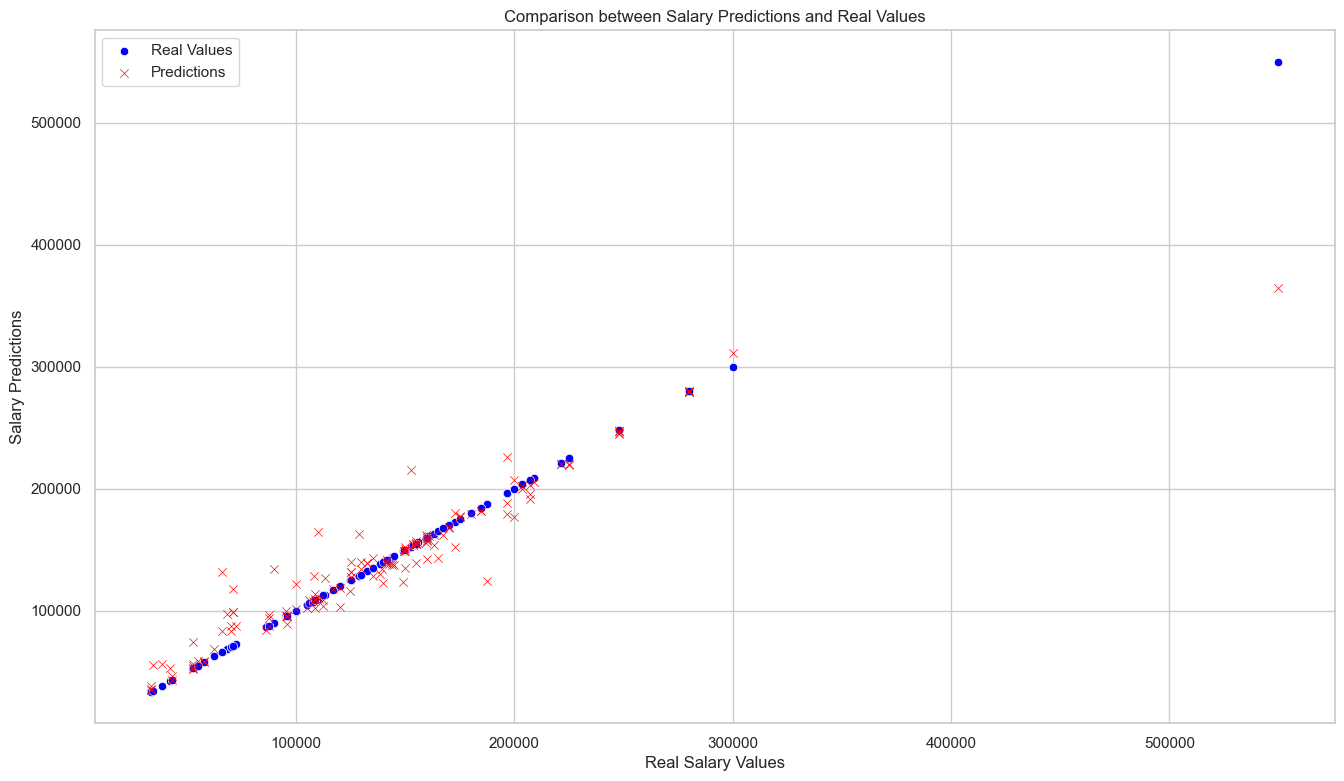

In [3321]:
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Real Values', marker='o')
sns.scatterplot(x=y_test, y=pred, color='red', label='Predictions', marker='x')

plt.xlabel('Real Salary Values')
plt.ylabel('Salary Predictions')
plt.title('Comparison between Salary Predictions and Real Values')
plt.legend()
# plt.savefig(f'../figures/RFRmodel_r2_{r2_pred}.jpg')
plt.show()

#### TESTS with X_test

In [3314]:
X_test_copy = X_test.copy()
X_test_copy['pred_salary'] = y_pred
X_test_copy['salary'] = y_test
X_test_copy.sample(5)

,job_id,job_title,remote_ratio,employment_type,experience_level,L,M,S,pred_salary,salary
328,3764903612,5,50,4,0,1.0,0.0,0.0,53047.0,52800.0
395,3767322672,4,50,4,3,1.0,0.0,0.0,79764.6,62500.0
325,3764827498,4,50,4,0,1.0,0.0,0.0,53860.2,52800.0
505,3770505264,4,50,4,3,0.0,1.0,0.0,198527.8,135000.0
317,3764675617,6,0,2,3,1.0,0.0,0.0,137856.0,66240.0


#### Predictions

In [3316]:
prediction = model.predict(prepared_to_predict.select_dtypes(exclude=['object']).drop(columns=['salary']))

In [3317]:
to_predict['pred_salary'] = prediction

In [3319]:
linkedin = pd.concat([linkedin, to_predict])
linkedin.to_csv('../data/predicted.csv')